# Chapter 8: Making Transformers Efficient in Production

In [1]:
%%html
<style>
.pad-left {
    padding-left: 20px;
}
</style>

## Background

> (W)hen developing a new machine learning model for your business, do you first make it accurate, then worry about making it fast in production? Or do you first make sure it can be fast, then make it accurate? 
> <p/>
> ...
> <p/>
> While this was a stressful experience for us, it doesn’t have to be for you, because in this article we are going to share the optimizations that made Bert inference fast for us. So you can start with an egg (a known playbook for making certain Bert models fast in production), then focus on the chicken (making your Bert model accurate).

* Blogpost@Robolox: [How We Scaled BERT to Serve 1+ Billion Daily Requests on CPUs](https://medium.com/@quocnle/how-we-scaled-bert-to-serve-1-billion-daily-requests-on-cpus-d99be090db26)
* And the [video from Databricks on YouTube](https://youtu.be/Nw77sEAn_Js)

#### Key takeaways

1. _Smaller Model_: model distillation
1. _Smaller Inputs_: do away with padding inputs and go with dynamically shaped input
1. _Smaller Weights_: although this may necessarily trade off accuracy, use quantization 
1. _Smaller number of requests_: use caching
1. _Smaller number of thread per core_: thread tuning with [`torch.set_num_threads`](https://www.theatlantic.com/ideas/archive/2024/01/the-daily-show-jon-stewart/677240/)

## Intent Detection as a Case Study

In [2]:
from transformers import pipeline

teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=teacher_ckpt)

2024-02-04 23:54:45.793716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""

pipe(query)

[{'label': 'car_rental', 'score': 0.5490036606788635}]

### CLINC150

A dataset for task-oriented dialog systems, this dataset was used to fine-tune the baseline model in this example. 

The important thing is that it actually includes queries that are out-of-scope.

Please see: [`clinc_oos` at 🤗](https://huggingface.co/datasets/clinc_oos)

In [4]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [5]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [6]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

----

## Creating a Performance Benchmark

In [7]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # tbd
        pass

    def compute_size(self):
        # tbd
        pass

    def time_pipeline(self):
        # tbd
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

#### Implementing `compute_accuracy`

In [8]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

/var/tmp/ipykernel_2744/3510557904.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")
/opt/conda/envs/transformers-py38/lib/python3.8/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [9]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)

    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

#### Implementing `compute_size`

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [11]:
import torch

torch.save(pipe.model.state_dict(), "model.pt")

In [12]:
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024*1024)
    # delete tmp file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

#### Implementing `time_pipeline`

In [13]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 46.001
Latency (ms) - 43.851
Latency (ms) - 40.909


In [14]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline method"""
    latencies = []

    # warm-up
    for _ in range(10):
        _ = self.pipeline(query)

    # now we observed the elapsed time over 100 runs
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)

    # compute run stats
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return { "time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms }

PerformanceBenchmark.time_pipeline = time_pipeline

In [15]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 24.06 +\- 0.31
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Creating a Knowledge Distillation Trainer

In addition to the _105_ parameters that [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments), we will add two more to support training of a student model with knowledge distillation:

* `alpha` ... $\alpha$ controls the weighted average of cross-entropy and knowledge-distillation loss for the student model (see below). Ranges from 0.0 to 1.0; $\alpha = 1.0$ means that we only use the cross-entropy of the student and ignore any signal from the teacher.
* `temperature` ... $T$ softens the probability distributions by scaling the logits before applying softmax:

<p class="pad-left">\(p_{i} = \frac{exp(z_i(x)/T)}{\sum_\limits{j}exp(z_{i}(x)/T)}\)</p>
<p>Ranges from 1.0 to $\infty$. $T=1$ recovers the original softmax distribution. </p>

In [16]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

During training, loss is calculated as a weighted average of the usual cross-entropy loss of the student; and the knowledge-distillation loss between the teacher and student. 

<p class="pad-left">\(L_{student} = \alpha L_{CE} + (1 - \alpha) L_{KD}\)</p>
<p>where</p>


<p class="pad-left">\(L_{CE}\)</p>
<p>is the cross-entropy loss of the ground truth labels.</p>

<p class="pad-left">\(L_{KD} = T^{2}D_{KL}\)</p><p>is knowledge-distillation loss where \(T^{2}\) is a normalization factor to account for the gradients produced by soft labels scales as \(\frac{1}{T^{2}}\).</p>

<p class="pad-left">\(D_{KL}(p, q) = \sum_\limits{i} p_i \  log\frac{p_i(x)}{q_i(x)}\)</p>
<p>which is the expectation of the log difference between $p_i(x)$ and $q_i(x)$ when the expectation is taken using the probabilities of $p_i(x)$. For our case, $p_i(x)$ is the <i>teacher</i> and $q_i(x)$ is the <i>student</i>. In other words, we measure loss by seeing how far off the student is from the teacher, and that makes perfect sense.</p>

In [17]:
import torch.nn as nn
import torch.nn.functional as F

from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        
        # extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits

        # soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1)
        )

        # return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

## Choosing a Good Student Initialization

> A good rule of thumb from the literature is that knowledge distillation works best when teacher and student are of the same _model type_.

So if we are using [BERT (`transformersbook/bert-base-uncased-finetuned-clinc`)](https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc) for teacher, then [DistilBERT (`distilbert-base-uncased`)](https://huggingface.co/distilbert-base-uncased) for the student is a natural choice.

In [18]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)


clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [20]:
from huggingface_hub import notebook_login

notebook_login()

We implement `compute_metrics` for tracking metrics during training. Here, we can reuse `accuracy_score` which we use above in `PerformanceBenchmark.compute_accuracy`.

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

#### Training arguments

* [`output_dir`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.output_dir) ... output directory where the model predictions and checkpoints will be written.
* [`evaluation_strategy`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.evaluation_strategy) ... `"no"`: No evaluation is done during training; `"steps"`: Evaluation is done (and logged) every eval_steps; or `"epoch"`: Evaluation is done at the end of each epoch.
* [`num_train_epochs`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.num_train_epochs(float,) ... number of training epochs to perform (if not an integer, will perform the decimal part percents of the last epoch before stopping training); defaults to 3.0.
* [`learning_rate`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.learning_rate) ... initial learning rate for [`transformers.AdamW`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/optimizer_schedules#transformers.AdamW) optimizer.
* [`weight_decay`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.weight_decay) ... weight decay to apply (if not zero) to all layers except all bias and `LayerNorm` weights in `transformers.AdamW` optimizer.
* [`per_device_train_batch_size`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.per_device_train_batch_size) ... batch size per GPU/TPU core/CPU for _training_; defaults to 8.
* [`per_device_eval_batch_size`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.per_device_eval_batch_size) ... batch size per GPU/TPU core/CPU for _evaluation_; defaults to 8.
* `alpha` ... controls the weighted average of cross-entropy and knowledge-distillation loss for the student model (see explanation above).
* `temperature` ... controls the softening of the probability distributions by scaling the logits before applying softmax (see explanation above).
* [`push_to_hub`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments.push_to_hub) ... push the model to the Hub every time the model is saved.

In [22]:
SEED = 8675309

In [23]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(
    seed=SEED,
    output_dir=finetuned_ckpt,
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # here are the 2 hyperparams for knowledge-distillation
    alpha=1,
    temperature=2.0,
    # to avoid those deprecation warnings
    optim="adamw_torch",
    #
    push_to_hub=True
)

#### Student model configuration

In [24]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

num_labels = intents.num_classes

In [25]:
from transformers import AutoConfig

student_config = AutoConfig.from_pretrained(
    student_ckpt,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
from transformers import AutoModelForSequenceClassification

def student_init():
    return (AutoModelForSequenceClassification.from_pretrained(
        student_ckpt,
        config=student_config
    ).to(device))

In [28]:
teacher_model = (AutoModelForSequenceClassification.from_pretrained(
    teacher_ckpt,
    num_labels=num_labels
).to(device))

In [29]:
%%time

distilbert_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.299764,0.713226
2,3.799600,1.873893,0.839032
3,3.799600,1.156364,0.890323
4,1.689000,0.857065,0.912581
5,0.901700,0.776097,0.917419


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


CPU times: user 6min 19s, sys: 29.8 s, total: 6min 49s
Wall time: 11min 51s


TrainOutput(global_step=1590, training_loss=2.053109031053459, metrics={'train_runtime': 329.3826, 'train_samples_per_second': 231.494, 'train_steps_per_second': 4.827, 'total_flos': 413143018435392.0, 'train_loss': 2.053109031053459, 'epoch': 5.0})

In [30]:
distilbert_trainer.push_to_hub("Fine-tuned student model training completed")

print("don't forget to add the knowledge-distillation hyperparameters to your model card!")

don't forget to add the knowledge-distillation hyperparameters to your model card!


----

#### ???

So, how is that fine-tuned model of ours?

In [31]:
finetuned_ckpt = "buruzaemon/distilbert-base-uncased-finetuned-clinc"

pipe = pipeline(
    "text-classification",
    model=finetuned_ckpt
)

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

In [32]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(
    pipe,
    clinc["test"],
    optim_type=optim_type
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 12.59 +\- 0.20
Accuracy on test set - 0.857


### Comparison: base-line model (Teacher) vs. fine-tuned (Student)

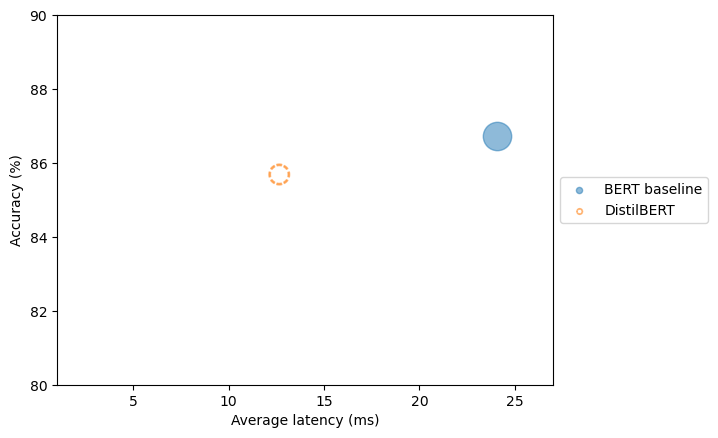

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(
                df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx,
                marker='$\u25CC$'
            )
        else:
            plt.scatter(
                df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx
            )
   
    legend = plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
    #for handle in legend.legendHandles:
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80, 90)

    # use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)         

#### Optuna

The default backend for hyperparameter search in HF is Optuna. Pretty neat!

In [34]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x)**2 + 100*(y - x**2)**2

In [35]:
import optuna

# while the logging from Optuna is very interesting,
#                                  ^^^^
# it is also very verbose!
#            ^^^^^^^^^^^^
# uncomment the line below to see it in all its glory
#
#optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2024-02-05 00:13:24,050] A new study created in memory with name: no-name-39577331-11cd-434c-af1c-b2f1852ff751
[I 2024-02-05 00:13:24,053] Trial 0 finished with value: 64.26248821176874 and parameters: {'x': 0.5238635663825528, 'y': -0.5257905719937597}. Best is trial 0 with value: 64.26248821176874.
[I 2024-02-05 00:13:24,055] Trial 1 finished with value: 15.581697253254482 and parameters: {'x': -1.1718259829386408, 'y': 1.0435571246276365}. Best is trial 1 with value: 15.581697253254482.
[I 2024-02-05 00:13:24,056] Trial 2 finished with value: 421.04887059907935 and parameters: {'x': 0.30925421136899933, 'y': -1.9551464164027754}. Best is trial 1 with value: 15.581697253254482.
[I 2024-02-05 00:13:24,057] Trial 3 finished with value: 483.2237285317853 and parameters: {'x': 1.7144642571453024, 'y': 0.7423140230880105}. Best is trial 1 with value: 15.581697253254482.
[I 2024-02-05 00:13:24,059] Trial 4 finished with value: 385.16901184904845 and parameters: {'x': 0.5293353253987871,

In [36]:
study.best_params

{'x': 1.0025420052288243, 'y': 1.0041530559308645}

Right, let's use `transformers.Trainer.hyperparameter_search` and Optuna to do a hyperparameter search for the best values (given a range) of:

1. `num_train_epochs`
2. `alpha`
3. `temperature`

We set up a function `hp_space` which returns a `dict` with the target hyperparameter names as keys, with `suggest_*` values. This function is what we pass to `hyperparameter_search` as the [`hp_space`](optuna.logging.set_verbosity(optuna.logging.WARNING)) argument.

In [37]:
def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_float("temperature", 2, 20)
    }

#### For reproducing the results of `hyperparameter_search`

In order to reproduce the results of `hyperparameter_search`, we pass in an additional keyword argument which will automagically be passed to the default Optuna backend as an argument to [`optuna.create_study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html#optuna-study-create-study). 

From this [blogpost Optunaでrandomのseedを固定する方法](https://qiita.com/phorizon20/items/1b795beb202c2dc378ed), something like this is possible for setting the seed that Optuna will use:

    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123))

In [38]:
%%time

best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20,
    direction="maximize",
    hp_space=hp_space,
    sampler=optuna.samplers.RandomSampler(seed=SEED)
)

[I 2024-02-05 00:13:38,038] A new study created in memory with name: no-name-994d99ec-3a09-41a4-bf65-87198445fe23
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.208558,0.596452
2,0.333500,0.099790,0.821290
3,0.333500,0.065401,0.880968
4,0.115900,0.049797,0.909032
5,0.072900,0.040866,0.920000
6,0.072900,0.035809,0.923548
7,0.056900,0.032958,0.926129
8,0.049900,0.031311,0.925806
9,0.049900,0.030726,0.926452


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 00:23:47,518] Trial 0 finished with value: 0.9264516129032258 and parameters: {'nu

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.277648,0.629355
2,0.433000,0.125479,0.821613
3,0.433000,0.078837,0.881935
4,0.145500,0.060148,0.905484
5,0.090700,0.051851,0.915161
6,0.090700,0.049289,0.917419


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 00:30:36,715] Trial 1 finished with value: 0.9174193548387096 and parameters: {'num_train_epochs': 6, 'alpha': 0.4090011273795646, 'temperature': 3.4782450741530457}. Best is trial 0 with value: 0.9264516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classif

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.366396,0.640323
2,0.566400,0.146653,0.823548
3,0.566400,0.082746,0.889677
4,0.169100,0.061405,0.907097
5,0.095700,0.052615,0.912903
6,0.095700,0.050050,0.917742


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 00:37:22,933] Trial 2 finished with value: 0.917741935483871 and parameters: {'num_train_epochs': 6, 'alpha': 0.4138809245395255, 'temperature': 2.3270127935496596}. Best is trial 0 with value: 0.9264516129032258.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193039,0.586129
2,0.309500,0.094852,0.810000
3,0.309500,0.063794,0.873548
4,0.109900,0.049287,0.904194
5,0.070600,0.040856,0.915806
6,0.070600,0.035979,0.922903
7,0.055600,0.033184,0.925484
8,0.048900,0.031559,0.924839
9,0.048900,0.030981,0.925161


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 00:47:32,428] Trial 3 finished with value: 0.9251612903225807 and parameters: {'nu

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.198920,0.583548
2,0.316000,0.099682,0.805161
3,0.316000,0.068440,0.867742
4,0.115300,0.054054,0.897097
5,0.076600,0.046285,0.910000
6,0.076600,0.042276,0.916129
7,0.063000,0.040881,0.919355


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 00:54:51,745] Trial 4 finished with value: 0.9193548387096774 and parameters: {'num_train_epochs': 7, 'alpha': 0.555179672553343, 'temperature': 14.915369008812359}. Best is trial 0 with value: 0.9264516129032258.
Some weights of DistilBertForSequenceClassificati

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.200448,0.579032


[I 2024-02-05 00:55:47,336] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.258076,0.601935
2,0.400200,0.125764,0.810968


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 00:57:55,040] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.201138,0.568387


[I 2024-02-05 00:58:51,098] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.276075,0.614194
2,0.426700,0.131222,0.812581


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 01:00:58,948] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.191335,0.588065


[I 2024-02-05 01:01:55,069] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.207536,0.598065
2,0.332900,0.098404,0.823871
3,0.332900,0.063918,0.883548
4,0.114400,0.048298,0.913226
5,0.071100,0.039251,0.920000
6,0.071100,0.034125,0.925806
7,0.054800,0.031108,0.927419
8,0.047300,0.029159,0.927097
9,0.047300,0.028282,0.929355
10,0.043500,0.027713,0.929355


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.320461,0.650645
2,0.505800,0.124436,0.839677
3,0.505800,0.068952,0.898710
4,0.145400,0.049860,0.921290
5,0.079100,0.040520,0.923871
6,0.079100,0.035728,0.929032
7,0.059800,0.033125,0.930968
8,0.052400,0.031614,0.931613
9,0.052400,0.031081,0.929677


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
[I 2024-02-05 01:22:46,106] Trial 11 finished with value: 0.9296774193548387 and parameters

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.233412,0.624516
2,0.372900,0.105155,0.835161
3,0.372900,0.065236,0.890645
4,0.122700,0.048239,0.915484
5,0.073400,0.038792,0.923871
6,0.073400,0.033684,0.927097
7,0.055800,0.030709,0.930323
8,0.048100,0.028803,0.929677
9,0.048100,0.027963,0.932258
10,0.044200,0.027414,0.931290


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.200417,0.593226


[I 2024-02-05 01:34:25,434] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202783,0.585806


[I 2024-02-05 01:35:21,148] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.203181,0.570323


[I 2024-02-05 01:36:16,720] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.238655,0.626452
2,0.380900,0.106399,0.834194
3,0.380900,0.065417,0.892903
4,0.124200,0.048202,0.915806
5,0.073700,0.038700,0.923871
6,0.073700,0.033626,0.927097
7,0.055900,0.030675,0.930323
8,0.048200,0.028789,0.930000
9,0.048200,0.027963,0.931935
10,0.044300,0.027416,0.931290


Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-finetuned-clinc/run-16/checkpoint-

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.246279,0.597742


[I 2024-02-05 01:47:54,956] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.208002,0.596774


[I 2024-02-05 01:48:50,722] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.213710,0.603548


[I 2024-02-05 01:49:46,280] Trial 19 pruned. 


CPU times: user 2h 3min 5s, sys: 3min 30s, total: 2h 6min 36s
Wall time: 1h 36min 8s


In [39]:
print(best_run)

BestRun(run_id='12', objective=0.9312903225806451, hyperparameters={'num_train_epochs': 10, 'alpha': 0.5858821400787321, 'temperature': 4.917005721212045}, run_summary=None)


In [40]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

distil_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer
)

distil_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.017169,0.727419
2,2.369100,1.047646,0.859032
3,2.369100,0.595615,0.909355
4,0.924400,0.399793,0.938065
5,0.400100,0.320544,0.944516
6,0.400100,0.281651,0.945806
7,0.240200,0.263070,0.948065
8,0.186000,0.258250,0.946774
9,0.186000,0.250496,0.948387
10,0.164500,0.249629,0.947742


Checkpoint destination directory distilbert-base-uncased-distilled-clinc/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-distilled-clinc/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-distilled-clinc/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-distilled-clinc/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-distilled-clinc/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilbert-base-uncased-distilled-clinc/checkpoint-3000 already exists and is non-empty.Savin

TrainOutput(global_step=3180, training_loss=0.6826041671465028, metrics={'train_runtime': 655.515, 'train_samples_per_second': 232.641, 'train_steps_per_second': 4.851, 'total_flos': 825755278130580.0, 'train_loss': 0.6826041671465028, 'epoch': 10.0})

In [41]:
distil_trainer.push_to_hub("Distilled student model training completed")

print("don't forget to add the knowledge-distillation hyperparameters to your model card! (see best_run)")

don't forget to add the knowledge-distillation hyperparameters to your model card! (see best_run)


### Benchmarking Our Distilled Model

In [42]:
distilled_ckpt = "buruzaemon/distilbert-base-uncased-distilled-clinc"

pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"

pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

Model size (MB) - 255.88
Average latency (ms) - 12.42 +\- 0.23
Accuracy on test set - 0.875


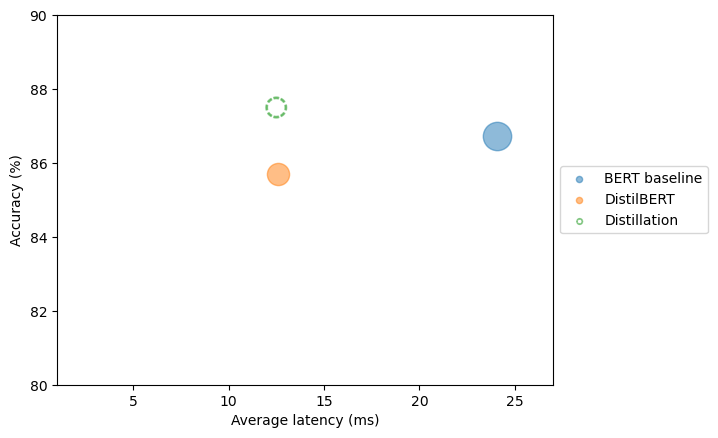

In [43]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

#### The range of model weight values is actually pretty limited.

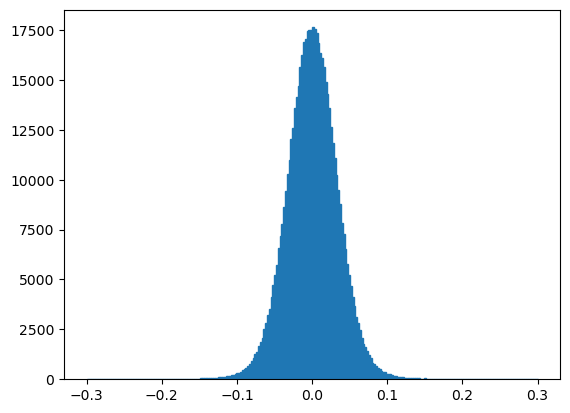

In [44]:
state_dict = pipe.model.state_dict()

weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]

plt.hist(
    weights.flatten().numpy(),
    bins=250,
    range=(-0.3, 0.3),
    edgecolor="C0",
)
plt.show()

_Discretization_ means taking the floating-point values $f$ in a tensor; map their range $\left[ f_{max}, f_{min} \right]$ into a smaller one $\left[ q_{max}, q_{min} \right]$ of fixed-point number $q$; then linearly distributing all values in between (the affine bit).

\begin{align}
  f = \left( \frac{f_{max} - f_{min}}{q_{max} - q_{min}} \right) \left(q - Z\right)
\end{align}

where 

$\left( \frac{f_{max} - f_{min}}{q_{max} - q_{min}} \right)$ is a scaling factor 


and _zero point_ $Z$, of the same type as $q$, is the quantized value of floating-point value $f = 0$.

In [45]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

#### Quantization the hard way

In [46]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   9],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   1,   5,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -8, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

#### Quantization the PyTorch way

In [47]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   9],
        [  9,   2,   1,  ...,  -4,   7,   1],
        [ -9,  -6,   5,  ...,   1,   5,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -8, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [48]:
%%timeit

weights @ weights

962 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [50]:
%%timeit 

q_fn.mul(quantized_weights, quantized_weights)

234 µs ± 9.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [51]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/var/tmp/ipykernel_2744/2099325647.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [52]:
torch.cuda.empty_cache()

import random
from torch.quantization import quantize_dynamic

# take our last, best model...
model_ckpt = "buruzaemon/distilbert-base-uncased-distilled-clinc"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (
    AutoModelForSequenceClassification
        .from_pretrained(model_ckpt)
        .to("cpu")
)

model_quantized = quantize_dynamic(
    model,
    {nn.Linear},
    dtype=torch.qint8
)

### Benchmarking Our Quantized Model

In [53]:
pipe = pipeline(
    "text-classification",
    model=model_quantized,
    tokenizer=tokenizer
)

optim_type = "Distillation + quantization"

pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 9.13 +\- 0.25
Accuracy on test set - 0.881


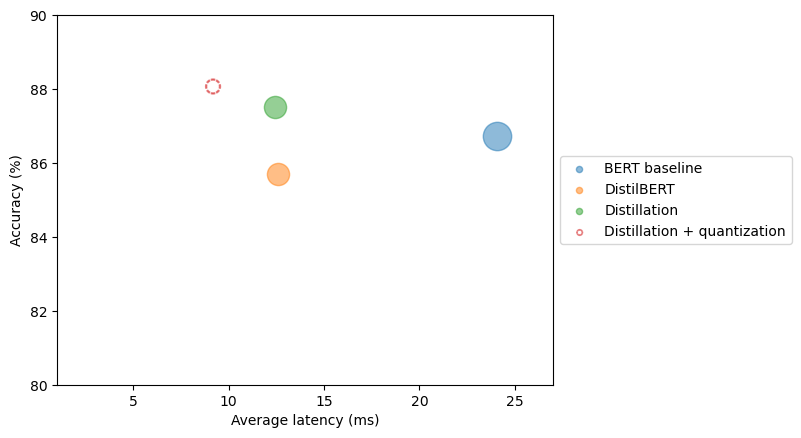

In [54]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONXX Runtime: Optimum

#### First simply convert `buruzaemon/distilbert-base-uncased-distilled-clinc` to ONNX

In [57]:
from pathlib import Path
from transformers import AutoTokenizer, pipeline
from optimum.onnxruntime import ORTModelForSequenceClassification

In [58]:
model_id = "buruzaemon/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# define a temporary local dir for storing the ONNX converted model, etc.
onnx_path = Path("onnx")
task = "text-classification"

In [61]:
# convert to ONNX via Optimum
model_onnx = ORTModelForSequenceClassification.from_pretrained(
    model_id,
    export=True
)

# save the ONNX-format model locally
model_onnx.save_pretrained(onnx_path)

Framework not specified. Using pt to export to ONNX.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.2.0+cu121


### Benchmarking Our Newly-converted Optimum Model

In [62]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024*1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [63]:
pipe = pipeline(
    "text-classification",
    model=model_onnx,
    tokenizer=tokenizer
)

optim_type = "Distillation + ORT"

pb = OnnxPerformanceBenchmark(
    pipe, 
    clinc["test"], 
    optim_type=optim_type,
    model_path="onnx/model.onnx"
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 5.28 +\- 0.10
Accuracy on test set - 0.875


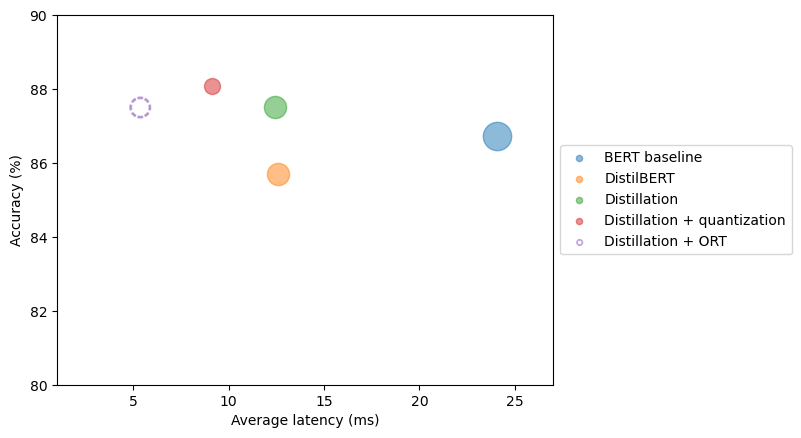

In [64]:
plot_metrics(perf_metrics, optim_type)

### Benchmarking Our The Optimum Model With Dynamic Quantization

From [Accelerated inference on NVIDIA GPUs, in Optimum How-To Guides](https://huggingface.co/docs/optimum/onnxruntime/usage_guides/gpu#accelerated-inference-on-nvidia-gpus)

> By default, ONNX Runtime runs inference on CPU devices. However, it is possible to place supported operations on an NVIDIA GPU, while leaving any unsupported ones on CPU. In most cases, this allows costly operations to be placed on GPU and significantly accelerate inference.
>
> (there is)<p/>
> `CUDAExecutionProvider`: Generic acceleration on NVIDIA CUDA-enabled GPUs.<br/>`TensorrtExecutionProvider`: Uses NVIDIA’s TensorRT inference engine and generally provides the best runtime performance.
> <p/>Due to a limitation of ONNX Runtime, it is not possible to run quantized models on CUDAExecutionProvider and only models with static quantization can be run on TensorrtExecutionProvider.

c.f. [https://huggingface.co/docs/optimum/onnxruntime/usage_guides/quantization#apply-dynamic-quantization](https://huggingface.co/docs/optimum/onnxruntime/usage_guides/quantization#apply-dynamic-quantization)

In [66]:
import onnxruntime

from onnxruntime.quantization.quantize import quantize_dynamic

In [67]:
from optimum.onnxruntime import ORTQuantizer

from optimum.onnxruntime.configuration import AutoQuantizationConfig

In [71]:
# Create quantizer
quantizer = ORTQuantizer.from_pretrained(model_onnx)

# Define the quantization strategy by creating the appropriate configuration
dqconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=False)

In [75]:
# define a temporary local dir for storing the ONNX converted model, etc.
onnx_path = Path("onnx_quantized")

# Quantize the model
model_quantized_path = quantizer.quantize(
    save_dir=onnx_path,
    quantization_config=dqconfig
)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: False)
Quantizing model...
Saving quantized model at: onnx_quantized (external data format: False)
Configuration saved in onnx_quantized/ort_config.json


In [77]:
model_onnx_q = ORTModelForSequenceClassification.from_pretrained(
    onnx_path, 
    file_name="model_quantized.onnx"
)

tokenizer = AutoTokenizer.from_pretrained(onnx_path)

pipe = pipeline(
    "text-classification",
    model=model_onnx_q,
    tokenizer=tokenizer
)

optim_type = "Distillation + ORT (quantized)"

pb = OnnxPerformanceBenchmark(
    pipe, 
    clinc["test"], 
    optim_type=optim_type,
    model_path= onnx_path / "model_quantized.onnx"
)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.38
Average latency (ms) - 3.86 +\- 0.11
Accuracy on test set - 0.885


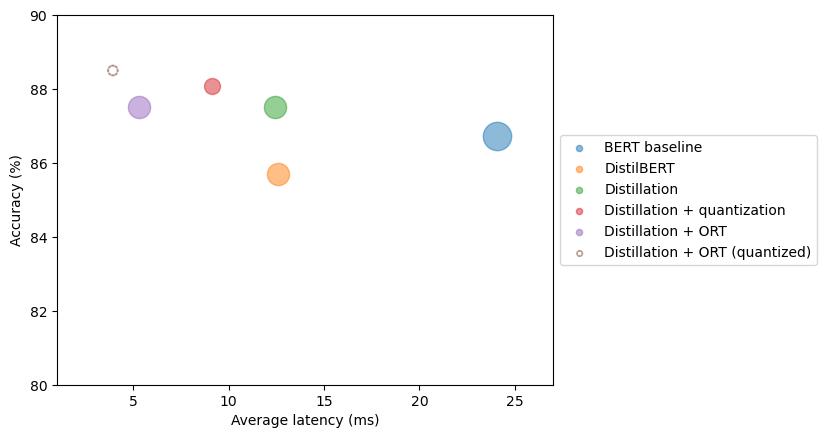

In [78]:
plot_metrics(perf_metrics, optim_type)